In [12]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

# Seaborn Styling
sns.set()
sns.set_context("paper", font_scale = 3, rc={"grid.linewidth": 3})
sns.set_style("whitegrid")

platforms = {
             "pypy": ['bfs','dfs', 'mst', 'dynamic-html', 'pagerank', 'compress', 'upload', 'thumbnail', 'video'],
             "jvm": ['matrix-multiplication', 'word-count', 'simple-hash', 'html-rendering']
            }
strategies = ['cold', 'fixed&request_to_checkpoint=1', 'request_centric&max_capacity=12' ]
mutabilities = [1]
df_columns = ['request_number', 'benchmark', 'mutability', 'strategy', 'rate', 'client', 'server', 'overhead']

# Figure 4

In [19]:
plt.style.use('bmh')

def python_latency_cdf(mode: str = 'client', save: str = False):
    function_titles = {
        "bfs": 'BFS',
        "dfs": 'DFS',
        "dynamic-html": 'DynamicHTML',
        "mst": 'MST',
        "pagerank": 'PageRank',
        "compress": 'Compression',
        "upload": 'Uploader',
        "thumbnail": 'Thumbnailer',
        "video": 'Video',
    }

    eviction_rates = [1, 4, 20]
    strategies = ['cold', 'fixed&request_to_checkpoint=1', 'request_centric&max_capacity=12']
    linestyles = ['--', '-.', '-']

    ncols = len(strategies)
    nrows = len(function_titles)

    fig, axs = plt.subplots(nrows, ncols, figsize=(10, 22), sharey=True)
    font_size = 15

    legend = {"handles": None, "labels": None}

    df = pd.read_csv(f'../data/python-evaluation.csv', names=df_columns)

    for i, (benchmark, title) in enumerate(function_titles.items()):
        for j, rate in enumerate(eviction_rates):                
            ax = axs[i, j]
            for k, strategy in enumerate(strategies):
                data = df[df['rate'] == rate]
                data = data[data['benchmark'] == benchmark]
                data=data[data['strategy'] == strategy]
                sns.ecdfplot(x=mode, data=data, label=strategy, ax=ax, linestyle=linestyles[k], linewidth=1.5, palette='tab10')
            if i == 0:
                if rate != 1:
                    ax.set_title(f"{rate} Requests", fontsize=font_size, y=1.05, weight='bold')
                else:
                    ax.set_title(f"{rate} Request", fontsize=font_size, y=1.05, weight='bold')
            else:
                pass
            ax.set_xlabel('', fontsize=font_size)
            ax.set_ylabel(f'{title}', fontsize=font_size, weight='bold')
            ax.tick_params(axis='both', which='major', labelsize=font_size)
            ax.set_ylim(0,)
            ax.legend([],[], frameon=False)
            legend["handles"], legend["labels"] = ax.get_legend_handles_labels()
            ax.set_xscale('log')
            smallest_nonzero_value = data[mode][data[mode] > 0].min()
            largest_nonzero_value = data[mode][data[mode] > 0].quantile(q=0.98)
            ax.set_xlim(smallest_nonzero_value, largest_nonzero_value)
            min_exponent = np.floor(np.log10(smallest_nonzero_value))
            max_exponent = np.ceil(np.log10(largest_nonzero_value))
            ticks = [10 ** exponent for exponent in np.linspace(min_exponent, max_exponent, num=3)]
            ax.set_xticks(ticks)
            # Define your formatter function
            def format_func(value, tick_number):
                exponent = int(np.floor(np.log10(abs(value))))
                mantissa = value/10**exponent
                return fr"${mantissa:.0f}e{{{exponent}}}$"
            # Use FuncFormatter to apply the format_func function to your x-axis
            from matplotlib.ticker import FuncFormatter
            ax.xaxis.set_major_formatter(FuncFormatter(format_func))
            ax.xaxis.set_minor_locator(ticker.NullLocator())

    fig.legend(legend['handles'], ['Cold', 'Checkpoint after 1st', 'Request-centric'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.92), frameon=False, prop={"weight":"bold", "size": font_size}).set_in_layout(True)
    plt.subplots_adjust(hspace=0.5) 
    sns.despine()

    if save:
        plt.savefig('python-latency-cdf.pdf', bbox_inches='tight')
    else:
        plt.show()

/tmp/ipykernel_2969055/3395768010.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(x=mode, data=data, label=strategy, ax=ax, linestyle=linestyles[k], linewidth=1.5, palette='tab10')
/tmp/ipykernel_2969055/3395768010.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(x=mode, data=data, label=strategy, ax=ax, linestyle=linestyles[k], linewidth=1.5, palette='tab10')
/tmp/ipykernel_2969055/3395768010.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(x=mode, data=data, label=strategy, ax=ax, linestyle=linestyles[k], linewidth=1.5, palette='tab10')
/tmp/ipykernel_2969055/3395768010.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(x=mode, data=data, label=strategy, ax=ax, linestyle=linestyles[k], linewidth=1.5, palette='tab10')
/tmp/ipykernel_2969055/3395768010.py:37: UserWarning: Ignoring `palette`

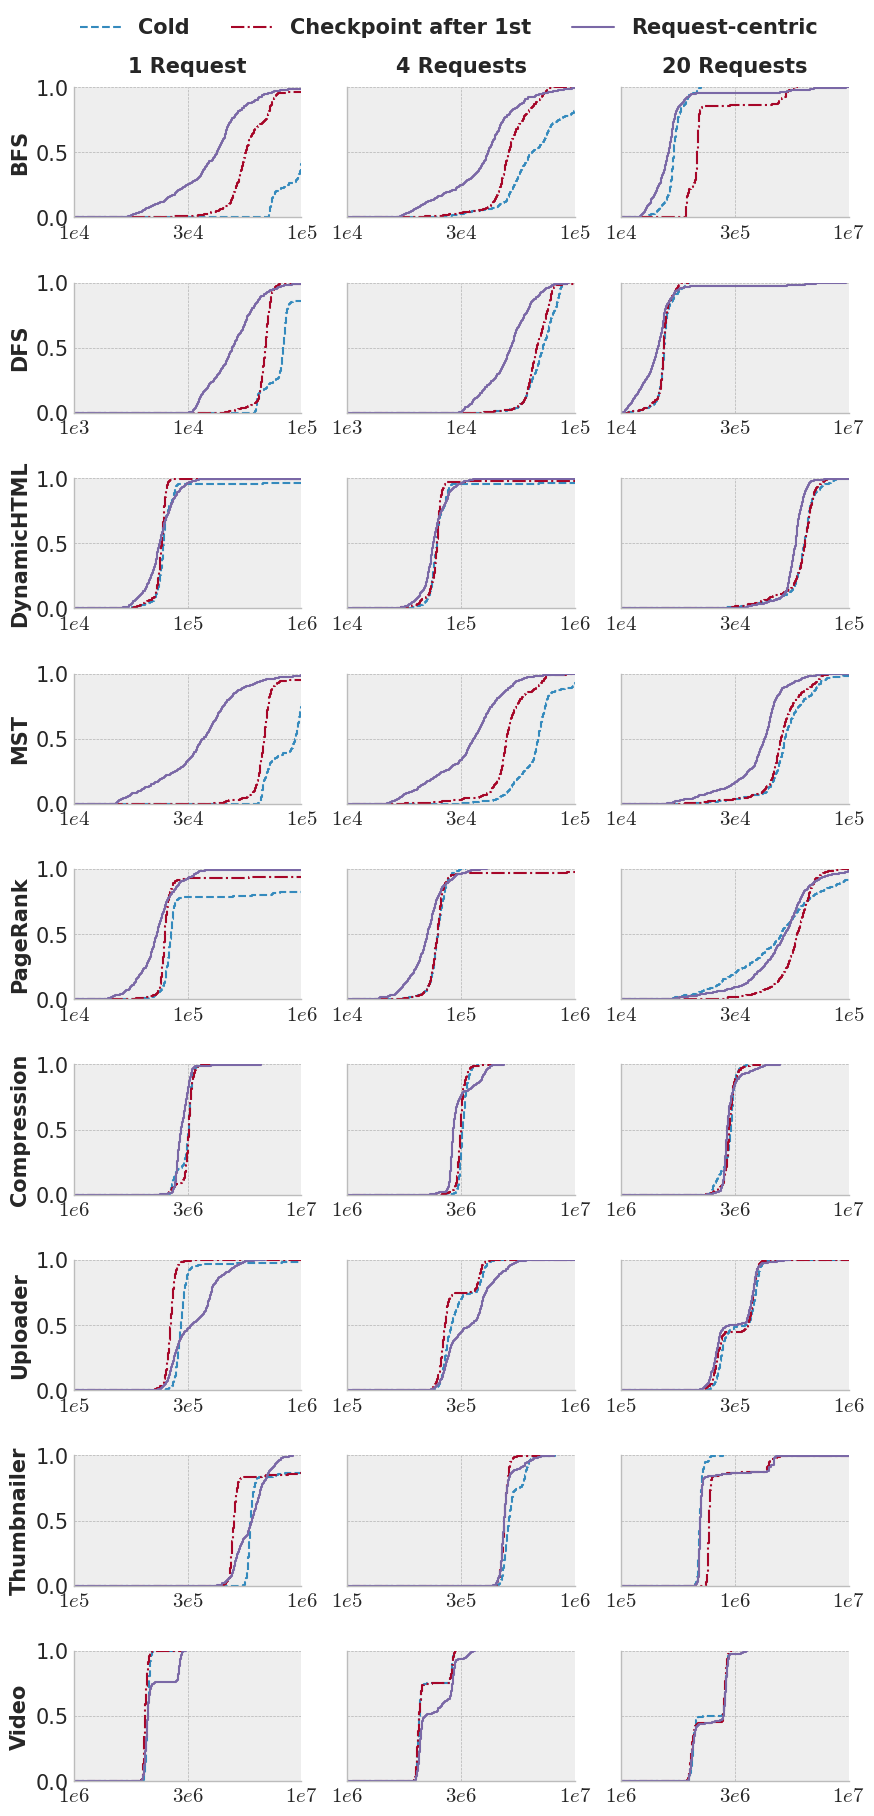

In [20]:
python_latency_cdf()

# Figure 5

In [21]:
plt.style.use('bmh')

def java_latency_cdf(mode: str = 'client', save: str = False):
    function_titles = {
        "matrix-multiplication": 'MatrixMult',
        "simple-hash": 'Hash',
        "html-rendering": 'HTMLRendering',
        "word-count": 'WordCount',
    }

    eviction_rates = [1, 4, 20]
    strategies = ['cold', 'fixed&request_to_checkpoint=1', 'request_centric&max_capacity=12']
    linestyles = ['--', '-.', '-']

    ncols = len(strategies)
    nrows = len(function_titles)

    fig, axs = plt.subplots(nrows, ncols, figsize=(8, 12), sharey=True)
    font_size = 15

    legend = {"handles": None, "labels": None}
    df = pd.read_csv(f'../data/java-evaluation.csv', names=df_columns)

    for i, (benchmark, title) in enumerate(function_titles.items()):
        for j, rate in enumerate(eviction_rates):                
            ax = axs[i, j]
            for k, strategy in enumerate(strategies):
                data = df[df['rate'] == rate]
                data = data[data['benchmark'] == benchmark]
                data=data[data['strategy'] == strategy]
                sns.ecdfplot(x=mode, data=data, label=strategy, ax=ax, linestyle=linestyles[k], linewidth=1.5, palette='tab10')
            if i == 0:
                if rate != 1:
                    ax.set_title(f"{rate} Requests", fontsize=font_size, y=1.05, weight='bold')
                else:
                    ax.set_title(f"{rate} Request", fontsize=font_size, y=1.05, weight='bold')
            else:
                pass
            ax.set_xlabel('', fontsize=font_size)
            ax.set_ylabel(f'{title}', fontsize=font_size, weight='bold')
            ax.tick_params(axis='both', which='major', labelsize=font_size)
            ax.set_ylim(0,)
            ax.legend([],[], frameon=False)
            legend["handles"], legend["labels"] = ax.get_legend_handles_labels()
            ax.set_xscale('log')
            smallest_nonzero_value = data[mode][data[mode] > 0].min()
            largest_nonzero_value = data[mode][data[mode] > 0].quantile(q=0.98)
            ax.set_xlim(smallest_nonzero_value, largest_nonzero_value)
            min_exponent = np.floor(np.log10(smallest_nonzero_value))
            max_exponent = np.ceil(np.log10(largest_nonzero_value))
            ticks = [10**x for x in range(int(np.floor(min_exponent)), int(np.ceil(max_exponent)) + 1)]
            ax.set_xticks(ticks)
            # Define your formatter function
            def format_func(value, tick_number):
                exponent = int(np.floor(np.log10(abs(value))))
                mantissa = value/10**exponent
                return fr"${mantissa:.0f}e{{{exponent}}}$"
            # Use FuncFormatter to apply the format_func function to your x-axis
            from matplotlib.ticker import FuncFormatter
            ax.xaxis.set_major_formatter(FuncFormatter(format_func))
            ax.xaxis.set_minor_locator(ticker.NullLocator())

    fig.legend(legend['handles'], ['Cold', 'Checkpoint after 1st', 'Request-centric'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.965), frameon=False, prop={"weight":"bold", "size": font_size}).set_in_layout(True)
    plt.subplots_adjust(hspace=0.5) 
    sns.despine()

    if save:
        plt.savefig('java-latency-cdf.pdf', bbox_inches='tight')
    else:
        plt.show()


/tmp/ipykernel_2969055/830582958.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(x=mode, data=data, label=strategy, ax=ax, linestyle=linestyles[k], linewidth=1.5, palette='tab10')
/tmp/ipykernel_2969055/830582958.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(x=mode, data=data, label=strategy, ax=ax, linestyle=linestyles[k], linewidth=1.5, palette='tab10')
/tmp/ipykernel_2969055/830582958.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(x=mode, data=data, label=strategy, ax=ax, linestyle=linestyles[k], linewidth=1.5, palette='tab10')
/tmp/ipykernel_2969055/830582958.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(x=mode, data=data, label=strategy, ax=ax, linestyle=linestyles[k], linewidth=1.5, palette='tab10')
/tmp/ipykernel_2969055/830582958.py:31: UserWarning: Ignoring `palette` beca

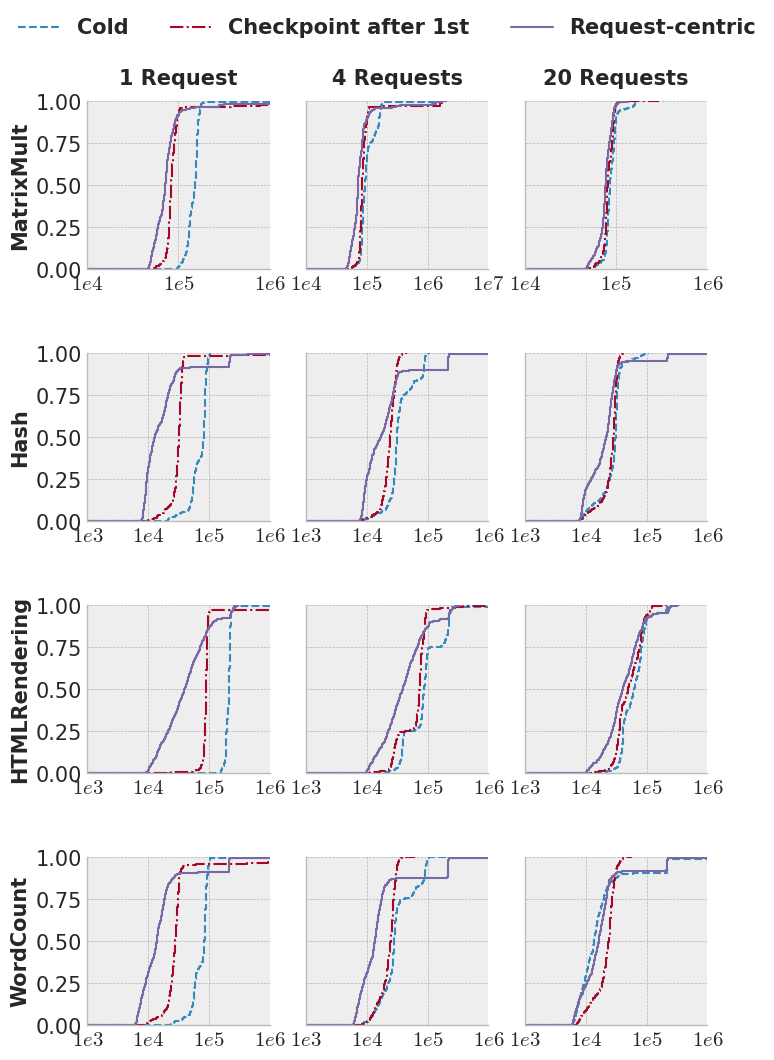

In [22]:
java_latency_cdf()